In [1]:
addprocs(4)

4-element Array{Int64,1}:
 2
 3
 4
 5

In [2]:
@everywhere function myrange(q::SharedArray)
    idx = indexpids(q)
    if idx == 0
        return 1:0, 1:0
    end
    nchunks = length(procs(q))
    splits = [round(Int, s) for s in linspace(0,round(Int, sqrt(size(q, 1))),nchunks+1)]
    1:round(Int, sqrt(size(q, 1))), splits[idx]+1:splits[idx+1]
end
@everywhere function Restriction_chunk!(level, x, Rx, irange, jrange)
    @show (irange, jrange)
    fine_length = 2^(level+1)-1
    coarse_length = 2^level-1
    for i in irange, j in jrange
        coarse_nd = (i-1)*coarse_length+j
        fine_nd = (2i-1)*fine_length+2j
        Rx[coarse_nd] += x[fine_nd]/4
        Rx[coarse_nd] += x[fine_nd+1]/8
        Rx[coarse_nd] += x[fine_nd-1]/8
        Rx[coarse_nd] += x[fine_nd+fine_length]/8
        Rx[coarse_nd] += x[fine_nd-fine_length]/8
        Rx[coarse_nd] += x[fine_nd+fine_length+1]/16
        Rx[coarse_nd] += x[fine_nd+fine_length-1]/16
        Rx[coarse_nd] += x[fine_nd-fine_length+1]/16
        Rx[coarse_nd] += x[fine_nd-fine_length-1]/16
    end
    Rx
end
@everywhere Restriction_shared_chunk!(level, x, Rx) = Restriction_chunk!(level, x, Rx, myrange(Rx)...)
function Restriction!(level, x)
    Rx = SharedArray(Float64, (2^level-1)^2)
    @sync begin
        for p in procs(Rx)
            @async remotecall_wait(Restriction_shared_chunk!, p, level, x, Rx)
        end
    end
    Rx
end


Restriction! (generic function with 1 method)

In [3]:
function Restriction_normal(level, x)
    fine_length = 2^(level+1)-1
    coarse_length = 2^level-1
    Rx = zeros(coarse_length^2)
    for i in 1:coarse_length, j in 1:coarse_length
        coarse_nd = (i-1)*coarse_length+j
        fine_nd = (2i-1)*fine_length+2j
        Rx[coarse_nd] += x[fine_nd]/4
        Rx[coarse_nd] += x[fine_nd+1]/8
        Rx[coarse_nd] += x[fine_nd-1]/8
        Rx[coarse_nd] += x[fine_nd+fine_length]/8
        Rx[coarse_nd] += x[fine_nd-fine_length]/8
        Rx[coarse_nd] += x[fine_nd+fine_length+1]/16
        Rx[coarse_nd] += x[fine_nd+fine_length-1]/16
        Rx[coarse_nd] += x[fine_nd-fine_length+1]/16
        Rx[coarse_nd] += x[fine_nd-fine_length-1]/16
    end
    Rx
end

Restriction_normal (generic function with 1 method)

In [97]:
level = 14
length = 2^level-1
x = SharedArray(Float64, length^2)
xx = rand(length^2)
for i in eachindex(x)
    x[i] = xx[i]
end
Rx = SharedArray(Float64, (2^(level-1)-1)^2);

In [98]:
@time res1 = Restriction_normal(level-1, x);

  6.025527 seconds (6 allocations: 511.875 MB, 0.05% gc time)


In [99]:
@time res2 = Restriction!(level-1, x);

	From worker 2:	(irange,jrange) = (1:8191,1:2048)
	From worker 5:	(irange,jrange) = (1:8191,6144:8191)
	From worker 4:	(irange,jrange) = (1:8191,4097:6143)
	From worker 3:	(irange,jrange) = (1:8191,2049:4096)
  2.633343 seconds (2.21 k allocations: 139.906 KB)


In [57]:
using PyPlot

In [119]:
times = [0.000037 0.00586;0.000095 0.004061;0.00032 0.00472;0.001236 0.007098; 
    0.007436 0.01276; 0.018497 0.034142; 0.075232 0.079056; 0.264552 0.278881; 6.025527 2.633343]
levels = 6:14

6:14

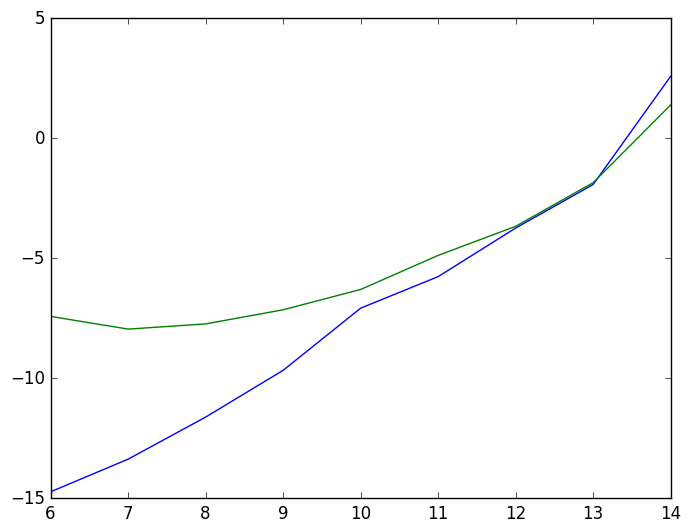

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31d3e0eb8>
 PyObject <matplotlib.lines.Line2D object at 0x31d3e5160>

In [120]:
plot(levels, log(2, times))